Data Source: MetaTrader 5

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA  
from statsmodels.tsa.stattools import adfuller
from scipy.stats.distributions import chi2 
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from math import sqrt
import seaborn as sns
import scipy.stats as stats
import pylab
import warnings
warnings.filterwarnings("ignore")
sns.set()

# Importing the Data and Pre-processing 

In [177]:
raw_csv_data = pd.read_csv("XAUUSD_DAILY.csv") 
df_comp=raw_csv_data.copy()
# Konversi tanggal
df_comp['date'] = pd.to_datetime(df_comp['DATE'], format='%m/%d/%Y')

# Set indeks
df_comp.set_index('date', inplace=True)

# Cek apakah ada duplikat
duplicates = df_comp.index.duplicated()

# Hapus duplikat (pilih yang pertama)
df_comp = df_comp[~df_comp.index.duplicated(keep='first')]

# Ubah frekuensi ke hari kerja
df_comp = df_comp.asfreq('b')
df_comp = df_comp.ffill()
df_comp

,DATE,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD
date,,,,,,,,
2004-06-11,6/11/2004,384.00,384.80,382.80,384.10,303.0,0.0,0.0
2004-06-14,6/14/2004,384.30,385.80,381.80,382.80,1954.0,0.0,0.0
2004-06-15,6/15/2004,382.80,388.80,381.10,388.60,1995.0,0.0,0.0
2004-06-16,6/16/2004,387.10,389.80,382.60,383.80,2106.0,0.0,0.0
2004-06-17,6/17/2004,383.60,389.30,383.00,387.60,1638.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-05-20,5/20/2025,3230.75,3295.68,3204.57,3289.66,94589.0,0.0,5.0
2025-05-21,5/21/2025,3289.94,3324.84,3285.56,3315.11,101469.0,0.0,5.0
2025-05-22,5/22/2025,3316.05,3345.31,3279.37,3294.71,100750.0,0.0,5.0


In [179]:
df_comp.isnull().sum()

DATE       0
OPEN       0
HIGH       0
LOW        0
CLOSE      0
TICKVOL    0
VOL        0
SPREAD     0
dtype: int64

In [183]:
adf_result = adfuller(df_comp['CLOSE'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] <= 0.05:
    print("✅ Series is stationary")
else:
    print("⚠️ Series is NOT stationary. Consider differencing.")

ADF Statistic: 1.8945988278417327
p-value: 0.9985192795725626
⚠️ Series is NOT stationary. Consider differencing.


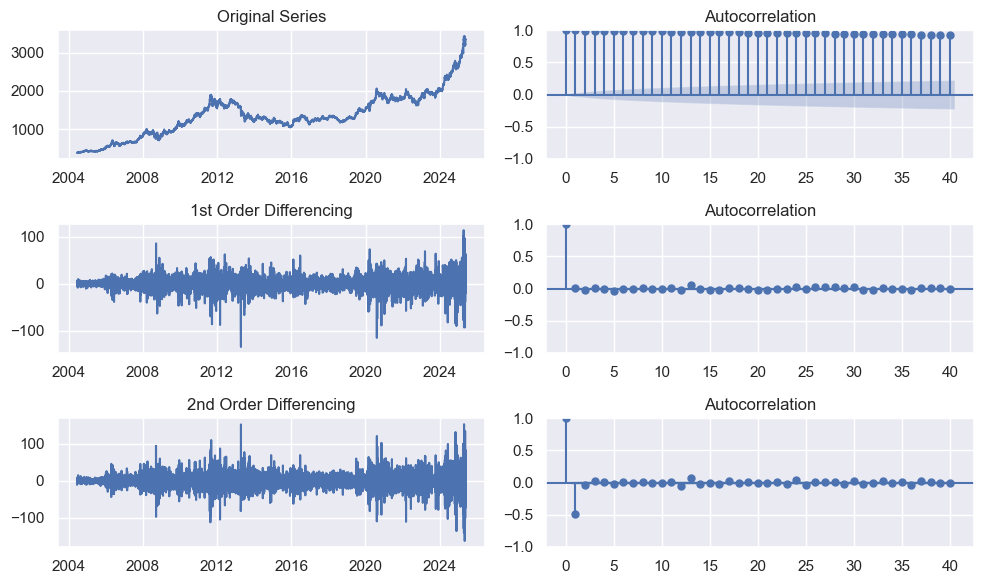

In [185]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (10, 6), 'figure.dpi': 100})

fig, axes = plt.subplots(3, 2)

axes[0, 0].plot(df_comp['CLOSE'])
axes[0, 0].set_title('Original Series')
plot_acf(df_comp['CLOSE'], ax=axes[0, 1], lags=40)

axes[1, 0].plot(df_comp['CLOSE'].diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_comp['CLOSE'].diff().dropna(), ax=axes[1, 1], lags=40)

axes[2, 0].plot(df_comp['CLOSE'].diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_comp['CLOSE'].diff().diff().dropna(), ax=axes[2, 1], lags=40)

plt.tight_layout()
plt.show()


As we could see, 1st order differencing is enough therefore ARIMA(p,1,q)

In [187]:
adf_result = adfuller(df_comp['CLOSE'].diff().dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] <= 0.05:
    print("✅ Series is stationary")
else:
    print("⚠️ Series is NOT stationary. Consider differencing.")

ADF Statistic: -19.32226951732989
p-value: 0.0
✅ Series is stationary


# Plot

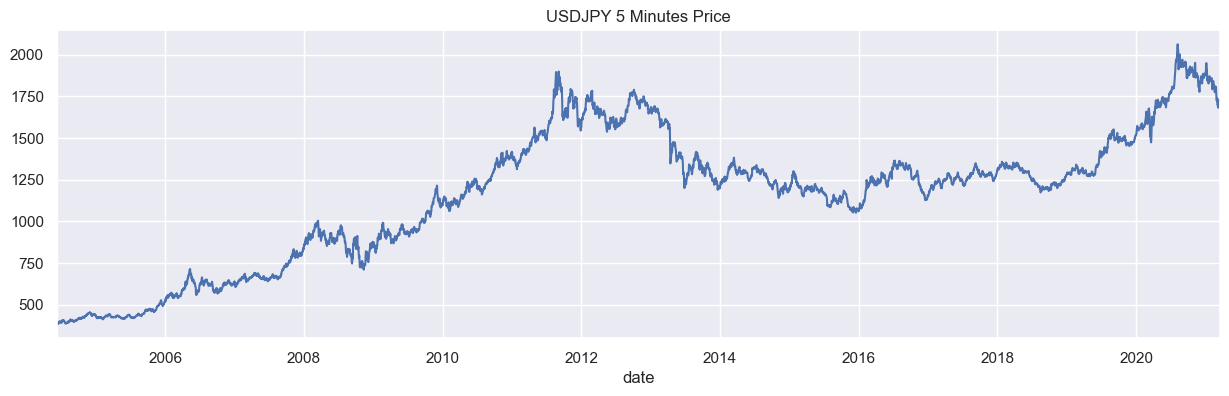

In [189]:
plt.figure(figsize=(15, 4))
df["CLOSE"].plot(title='USDJPY 5 Minutes Price')
plt.show()

# Train split data

In [191]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

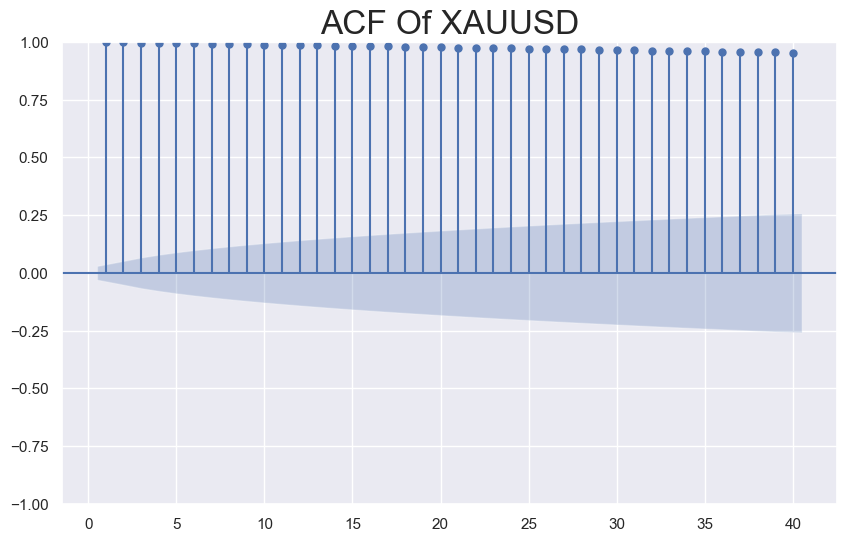

In [193]:
sgt.plot_acf(df.CLOSE, zero = False, lags = 40)
plt.title('ACF Of XAUUSD',size = 24)
plt.show()

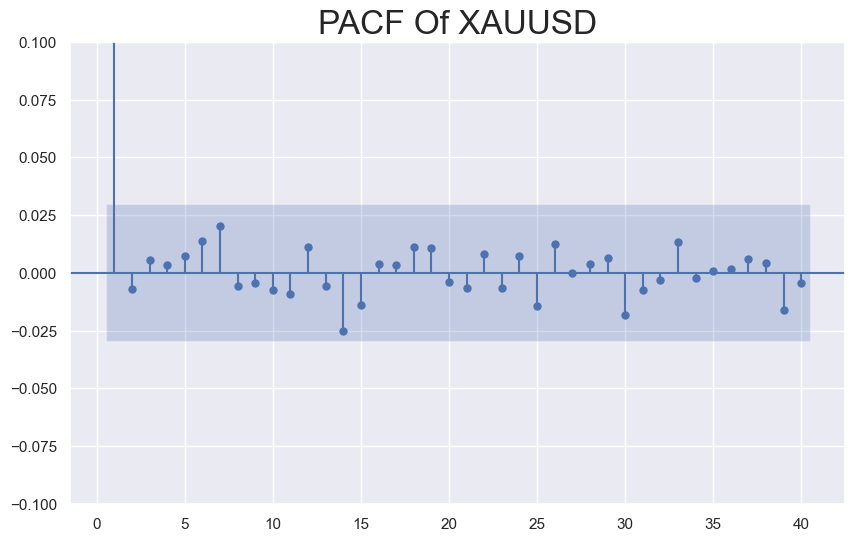

In [195]:
sgt.plot_pacf(df.CLOSE, zero = False, lags = 40)
plt.title('PACF Of XAUUSD',size = 24)
plt.ylim(-0.1,0.1)
plt.show()

In [197]:
model = auto_arima(df['CLOSE'],
                   seasonal = False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4373
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -17448.507
Date:                Mon, 26 May 2025   AIC                          34901.014
Time:                        10:15:32   BIC                          34913.780
Sample:                    06-11-2004   HQIC                         34905.519
                         - 03-16-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3083      0.204      1.514      0.130      -0.091       0.707
sigma2       171.4097      1.622    105.686      0.000     168.231     174.589
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):             14550.99
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

“naive model” seems performs better than overcomplicated ones because it behave like random walk in this simple arima model, we dont takes account the seasonality and trend.

In [201]:
predictions_arima = model.predict(n_periods = len(df_test))
predictions_arima

2021-03-17    1732.158269
2021-03-18    1732.466537
2021-03-19    1732.774806
2021-03-22    1733.083074
2021-03-23    1733.391343
                 ...     
2025-05-20    2067.862694
2025-05-21    2068.170963
2025-05-22    2068.479231
2025-05-23    2068.787500
2025-05-26    2069.095769
Freq: B, Length: 1094, dtype: float64

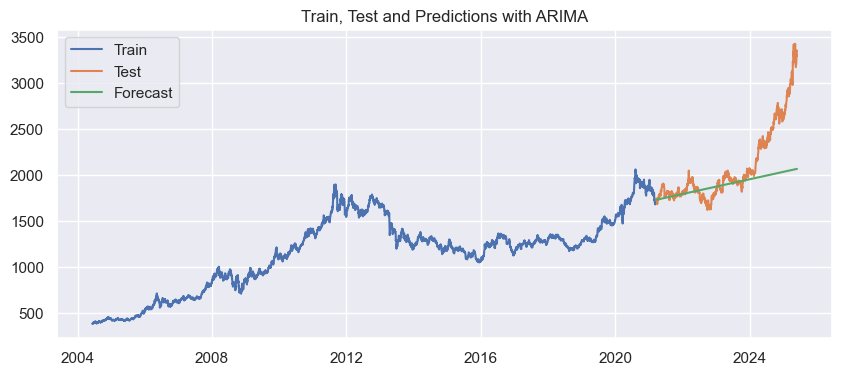

The MAE is 226.82
The RMSE is 377.78
The MAPE is 9.05 %


In [213]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = root_mean_squared_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

# Model assessment
model_assessment(df['CLOSE'], df_test['CLOSE'], predictions_arima, "ARIMA")

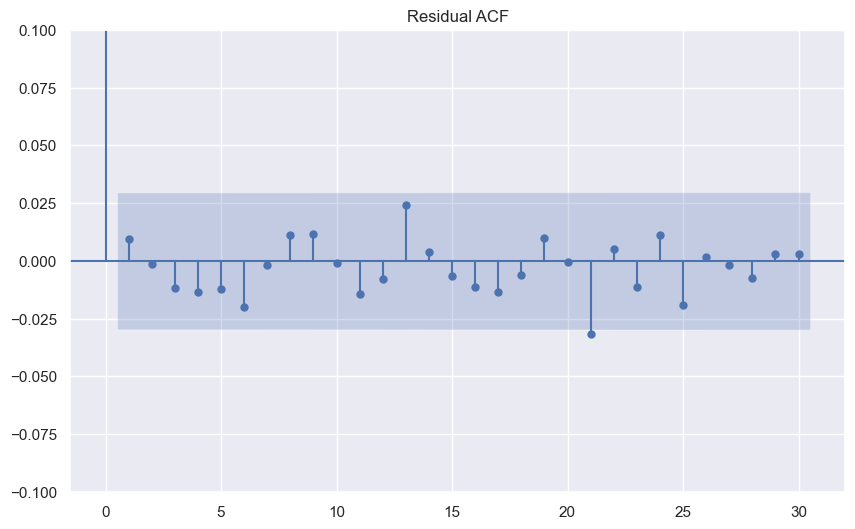

In [220]:
import statsmodels.api as sm
residuals = pd.Series(model.resid())
sm.graphics.tsa.plot_acf(residuals, lags=30)
plt.title("Residual ACF")
plt.ylim(-0.1,0.1)
plt.show()

It's behave like a white noise

In [222]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(model.resid(), lags=[10], return_df=True)


,lb_stat,lb_pvalue
10,5.345977,0.866901


Base on Ljung-Box Test, the model has captured the autocorrelation structure of the data well, Your model's residuals behave like white noise (i.e., no remaining structure).